# Palmer Penguin Dataset

![picture](https://www.gabemednick.com/post/penguin/featured_hu23a2ff6767279debab043a6c8f0a6157_878472_720x0_resize_lanczos_2.png)

The Palmer Penguin dataset contains different body measurements for three species of penguins from three islands in the Palmer Archipelago, in Antarctica. The aim of this project is to predict the penguins' species given their anatomical information, so this is a classification problem.

# Load the dataset

First of all, I will load the Palmer Penguin Dataset as a pandas dataframe and take a look at it.

In [ ]:
import pandas as pd

url = 'https://raw.githubusercontent.com/mwaskom/seaborn-data/master/penguins.csv'

names = ['species','island','culmen_length_mm','culmen_depth_mm','flipper_length_mm','body_mass_g','sex']
df = pd.read_csv(url, names = names, skiprows=1)
df

,species,island,culmen_length_mm,culmen_depth_mm,flipper_length_mm,body_mass_g,sex
0,Adelie,Torgersen,39.1,18.7,181.0,3750.0,MALE
1,Adelie,Torgersen,39.5,17.4,186.0,3800.0,FEMALE
2,Adelie,Torgersen,40.3,18.0,195.0,3250.0,FEMALE
3,Adelie,Torgersen,NaN,NaN,NaN,NaN,NaN
4,Adelie,Torgersen,36.7,19.3,193.0,3450.0,FEMALE
...,...,...,...,...,...,...,...
339,Gentoo,Biscoe,NaN,NaN,NaN,NaN,NaN
340,Gentoo,Biscoe,46.8,14.3,215.0,4850.0,FEMALE
341,Gentoo,Biscoe,50.4,15.7,222.0,5750.0,MALE
342,Gentoo,Biscoe,45.2,14.8,212.0,5200.0,FEMALE


The dimension of the dataset is the following:

In [ ]:
df.shape

(344, 7)

The dataset contains 7 columns, with the following meaning:
1. species: penguin species (Chinstrap, Adélie, or Gentoo)
2. culmen_length_mm: culmen length (mm)
3. culmen_depth_mm: culmen depth (mm)
4. flipper_length_mm: flipper length (mm)
5. body_mass_g: body mass (g)
6. island: island name (Dream, Torgersen, or Biscoe) in the Palmer Archipelago (Antarctica)
7. sex: penguin sex

The culmen, also called *bill*, is the upper ridge of the penguin's beak, while *flippers* is the name of the penguin's wings.

![image](https://allisonhorst.github.io/palmerpenguins/reference/figures/culmen_depth.png)

# Inspection of the dataset

In [ ]:
# all the imports needed

from matplotlib import pyplot as plt

from sklearn.impute import SimpleImputer

from sklearn.preprocessing import LabelEncoder, MinMaxScaler, StandardScaler

from sklearn.feature_selection import SelectKBest, chi2, f_classif

from sklearn.model_selection import KFold, cross_val_score, train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import SVC

from sklearn.metrics import confusion_matrix,  ConfusionMatrixDisplay, classification_report

import plotly.express as px
import seaborn as sns
import numpy as np

Before doing anything with the dataset I need to inspect it and understand what we are working with.

## Exploration of categorical attributes

As we are working in a classification setting I want to know the distribution of the 3 classes, so the species. As we can see, the dataset is the least descriptive of the Chinstrap species.

In [ ]:
df['species'].unique()

array(['Adelie', 'Chinstrap', 'Gentoo'], dtype=object)

In [ ]:
df.groupby('species').size() 

species
Adelie       152
Chinstrap     68
Gentoo       124
dtype: int64

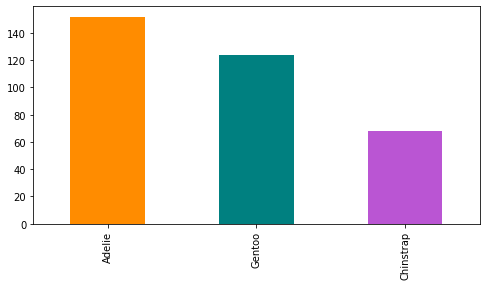

In [ ]:
df['species'].value_counts().plot(kind='bar', color=['darkorange','teal','mediumorchid'], figsize=(8,4))
plt.show()



---



Let's also check the distribution of the categorical class *island*. I notice that Torgersen island is significantly under-represented.

In [ ]:
df['island'].unique()

array(['Torgersen', 'Biscoe', 'Dream'], dtype=object)

In [ ]:
df.groupby('island').size() 

island
Biscoe       168
Dream        124
Torgersen     52
dtype: int64

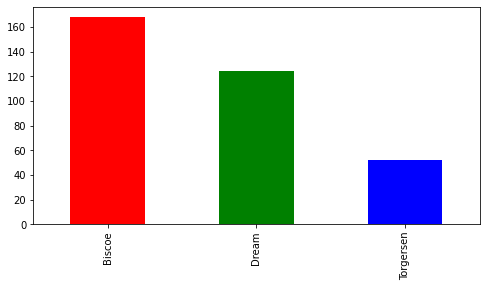

In [ ]:
df['island'].value_counts().plot(kind='bar', color=['red','green','blue'], figsize=(8,4))
plt.show()

Initially I suspected that the 3 Penguin species were geographically isolated on the 3 islands. However from the different distributions of the classes *species* and *island* I understand that this is not case. Let's visualize this.

I notice that Torgersen island only hosts Adelie penguins, but Adelie penguins populate the other 2 islands as well. Also, Chinstrap are present only on Dream and Gentoo only on Biscoe.

In [ ]:
island_df = pd.DataFrame(df.groupby(["island", "species"])["island"].count()).rename(columns={"island": "count"})
island_df

count
island    species         
Biscoe    Adelie        44
          Gentoo       124
Dream     Adelie        56
          Chinstrap     68
Torgersen Adelie        52

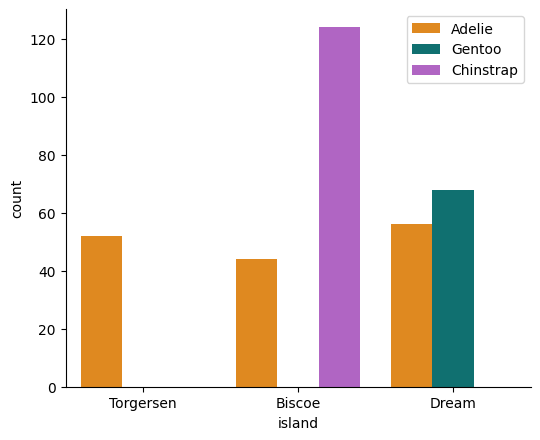

In [ ]:
fig, ax = plt.subplots(figsize=(6, 5), dpi=100)

plot = sns.countplot(data=df, x='island', hue='species', palette=['darkorange','teal','mediumorchid'])
plot.set_xticklabels(['Torgersen','Biscoe','Dream'])
plot.legend(labels=['Adelie','Gentoo','Chinstrap'])
sns.despine()

## Handling missing values

We just explored the fields *species* and *island* and observed that they do not contain any missing values. I want to check if this is the case also for the other attributes. I notice that there are 2 missing values for the fields *culmen_length_mm*, *culmen_depth_mm*, *flipper_length_mm*, *body_mass_g* and 11 missing values for the *sex* column. I will first investigate the missing values and then decide how to handle them.

In [ ]:
df.isna().sum()

species               0
island                0
culmen_length_mm      2
culmen_depth_mm       2
flipper_length_mm     2
body_mass_g           2
sex                  11
dtype: int64

Let's focus on the *sex* class, which is the attribute where most of the missing values are located. I notice that, regardless of the 11 missing values, the 2 sexes are very evenly represented, with around 50% female and 50% male.

In [ ]:
df['sex'].unique()

array(['MALE', 'FEMALE', nan], dtype=object)

In [ ]:
df.groupby('sex').size()

sex
FEMALE    165
MALE      168
dtype: int64

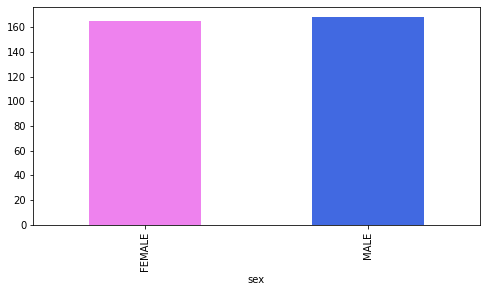

In [ ]:
df.groupby('sex').size().plot(kind='bar', y='sex', color=['violet','royalblue'], figsize=(8,4))
plt.show()

Now let's see how the missing values are distributed in the dataset.

In [ ]:
df[df.isnull().any(axis=1)]

,species,island,culmen_length_mm,culmen_depth_mm,flipper_length_mm,body_mass_g,sex
3,Adelie,Torgersen,NaN,NaN,NaN,NaN,NaN
8,Adelie,Torgersen,34.1,18.1,193.0,3475.0,NaN
9,Adelie,Torgersen,42.0,20.2,190.0,4250.0,NaN
10,Adelie,Torgersen,37.8,17.1,186.0,3300.0,NaN
11,Adelie,Torgersen,37.8,17.3,180.0,3700.0,NaN
47,Adelie,Dream,37.5,18.9,179.0,2975.0,NaN
246,Gentoo,Biscoe,44.5,14.3,216.0,4100.0,NaN
286,Gentoo,Biscoe,46.2,14.4,214.0,4650.0,NaN
324,Gentoo,Biscoe,47.3,13.8,216.0,4725.0,NaN
336,Gentoo,Biscoe,44.5,15.7,217.0,4875.0,NaN


I see that 2 penguins, number 3 and number 339, lack almost all information; while the other ones only lack the *sex* data. I decided to deal with these two cases differently: I will drop the penguins that are not informative (number 3 and 339) and I will impute the data for the other ones. 

The reasoning behind this choice is that I may not care about missing the sex data for the purpose of the classification, so dropping the entire row, including the other attributes that may be useful, could be a little extreme.

First I will drop the penguins that lack all information in the following colums: *culmen_length_mm*, *culmen_depth_mm*, *flipper_length_mm*, *body_mass_g*, *sex*.


In [ ]:
df.dropna(axis=0, how='all', subset=['culmen_length_mm','culmen_depth_mm','flipper_length_mm','body_mass_g','sex'], inplace=True)
df[df.isnull().any(axis=1)]

,species,island,culmen_length_mm,culmen_depth_mm,flipper_length_mm,body_mass_g,sex
8,Adelie,Torgersen,34.1,18.1,193.0,3475.0,NaN
9,Adelie,Torgersen,42.0,20.2,190.0,4250.0,NaN
10,Adelie,Torgersen,37.8,17.1,186.0,3300.0,NaN
11,Adelie,Torgersen,37.8,17.3,180.0,3700.0,NaN
47,Adelie,Dream,37.5,18.9,179.0,2975.0,NaN
246,Gentoo,Biscoe,44.5,14.3,216.0,4100.0,NaN
286,Gentoo,Biscoe,46.2,14.4,214.0,4650.0,NaN
324,Gentoo,Biscoe,47.3,13.8,216.0,4725.0,NaN
336,Gentoo,Biscoe,44.5,15.7,217.0,4875.0,NaN


Now in the dataset there are penguins that only lack the sex information. So I will use Scikit Learn to substitute the missing value in the *sex* field with the most frequent value in that column.

In [ ]:
imputer = SimpleImputer(strategy='most_frequent')
df.iloc[:,:] = imputer.fit_transform(df)

df.isnull().sum()

species              0
island               0
culmen_length_mm     0
culmen_depth_mm      0
flipper_length_mm    0
body_mass_g          0
sex                  0
dtype: int64

In [ ]:
# Check that the method worked as expected
df.iloc[10:11]

,species,island,culmen_length_mm,culmen_depth_mm,flipper_length_mm,body_mass_g,sex
11,Adelie,Torgersen,37.8,17.3,180.0,3700.0,MALE


The missing values in the sex field were filled with the most frequently occuring values in that column, which was 'MALE'. By doing so, I skewed the sex distribution: before we had 165 females, 168 males and 11 missing data, after imputing we have 165 females, 177 males and no missing data.

In [ ]:
df.groupby('sex').size()

sex
FEMALE    165
MALE      177
dtype: int64

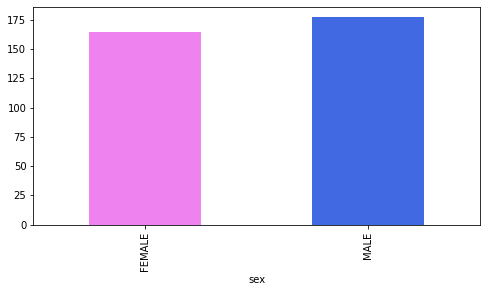

In [ ]:
df.groupby('sex').size().plot(kind='bar', y='sex', color=['violet','royalblue'], figsize=(8,4))
plt.show()

Imputing data allowed me to retain 9 penguins, which is important because the dataset is quite small. I deem unlikely that I will use the *sex* attribute as feature to predict the penguins species. However, if I were to use imputed data as features, I would have to keep in mind that by imputing I may have introduced some bias.

## Exploration of non-categorical attributes and encoding

I thoroughly inspected the categorical classes and imputed data where needed. I will now do the same the non-categorical attributes. First of all, I notice that these features are in different value ranges so feature scaling may be useful. 


In [ ]:
print(df.describe())

       culmen_length_mm  culmen_depth_mm  flipper_length_mm  body_mass_g
count        342.000000       342.000000         342.000000   342.000000
mean          43.921930        17.151170         200.915205  4201.754386
std            5.459584         1.974793          14.061714   801.954536
min           32.100000        13.100000         172.000000  2700.000000
25%           39.225000        15.600000         190.000000  3550.000000
50%           44.450000        17.300000         197.000000  4050.000000
75%           48.500000        18.700000         213.000000  4750.000000
max           59.600000        21.500000         231.000000  6300.000000


To get a better idea of these measurements I will exploit data visualization, using both univariate and multivariate plots.

Univariate plots are useful to understand each attribute independently: I will draw histograms and density plots to look at the distribution and trend of the data, and Box and Whisker plots to investigate possible outliers.

Multivariate plots, such as a correlation matrix and a scatterplot matrix, will help me to understand the relationships between variables.

### Univariate plots

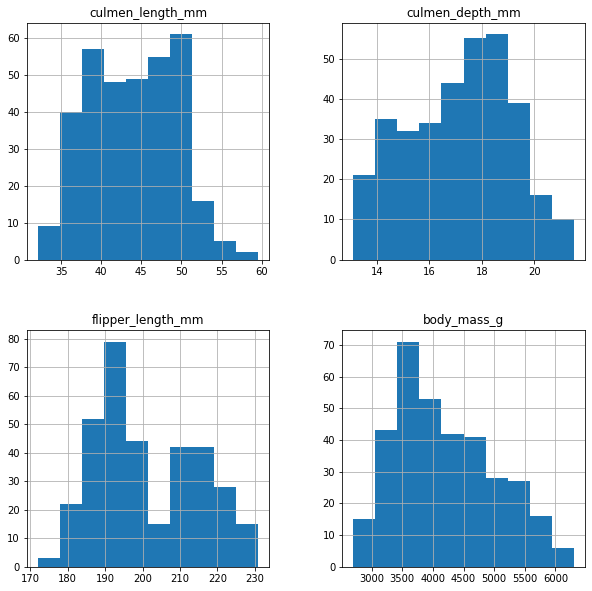

In [ ]:
# Histograms
df.hist()
plt.rcParams["figure.figsize"] = [11,11]
plt.show()

The distribution of the *flipper_length_mm* makes me think that this characteristic could separate the data into 2 groups. Also, none of the attributes seem to follow a Gaussian distribution.

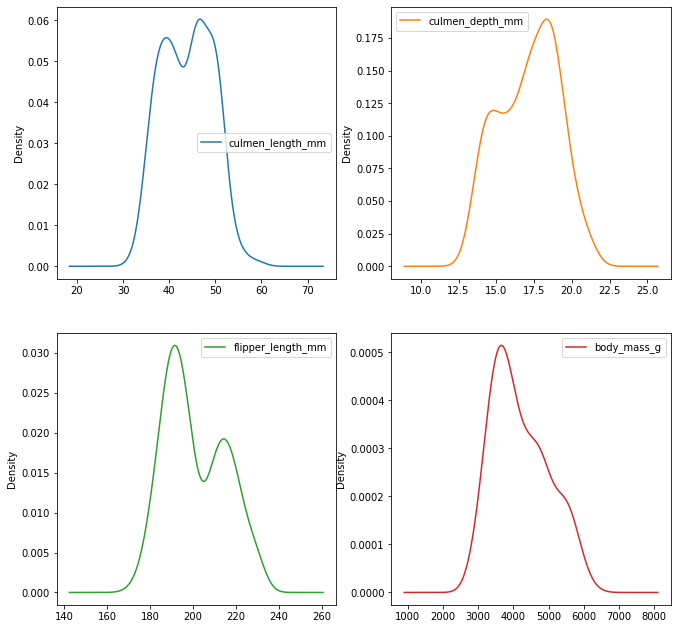

In [ ]:
# Density plots
df.plot(kind='density', subplots=True, layout=(2,2), sharex=False)
plt.rcParams["figure.figsize"] = [11,11]
plt.show()

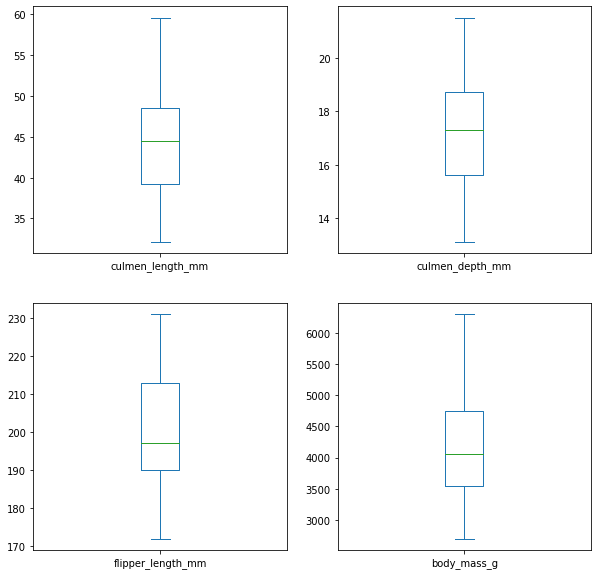

In [ ]:
# Boxplots
plt.rcParams["figure.figsize"] = [10,10]
df.plot(kind='box', subplots=True, layout=(2,2), sharex=False, sharey=False)
plt.show()

The data are consistent and do not present any outliers.

### Multivariate plots and encoding

Now let's see if there is correlation among the data. This strategy will allow me to figure out the important features that account the most for the classification.

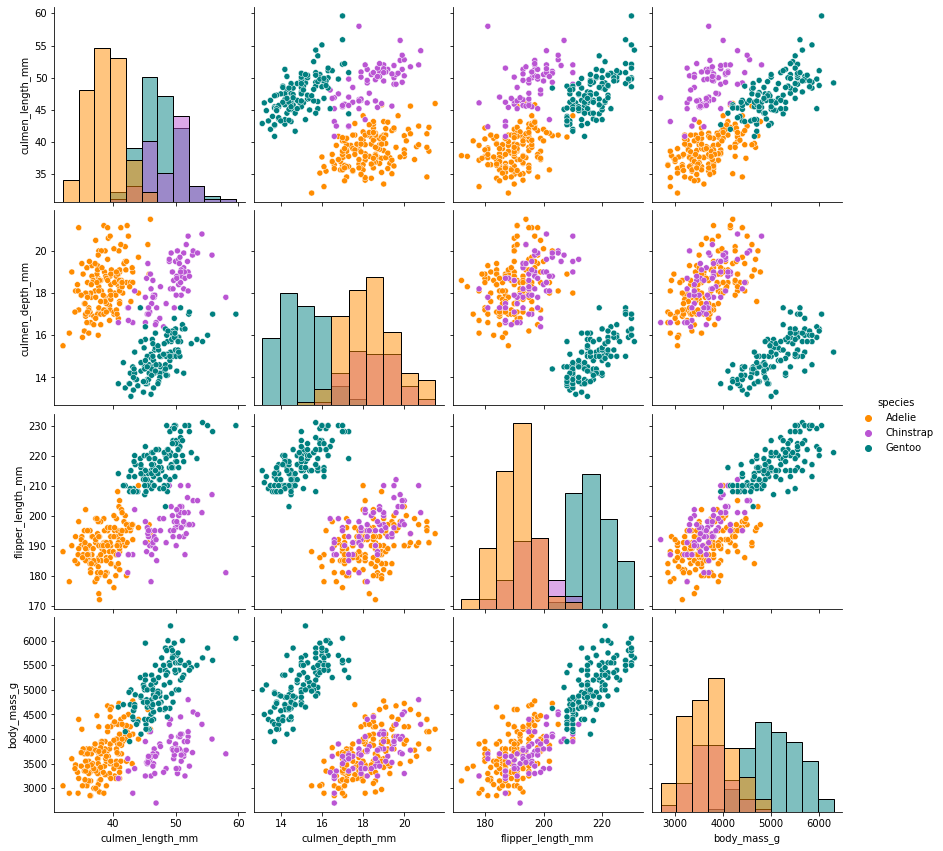

In [ ]:
# Scatterplot matrix to see pair-wise correlation
sns.pairplot(df, hue="species", height=3, diag_kind="hist", palette=['darkorange','mediumorchid','teal'])
plt.show()

I notice a strong positive correlation between body mass (*body_mass_g*) and flipper length (*flipper_length_mm*).

Correlation is not calculated for categorical values but I suspect that there is correlation between body size and sex, and maybe between 2 other variables as well. 

I will now perform one-hot encoding of the categorical variables in order to visualize how they correlate with the numerical data. To do so, I will use the pandas **get_dummies** function to one-hot encode *sex* and *island* and **LabelEncoder** to encode the target *species*.

In [ ]:
df.head()

,species,island,culmen_length_mm,culmen_depth_mm,flipper_length_mm,body_mass_g,sex
0,Adelie,Torgersen,39.1,18.7,181.0,3750.0,MALE
1,Adelie,Torgersen,39.5,17.4,186.0,3800.0,FEMALE
2,Adelie,Torgersen,40.3,18.0,195.0,3250.0,FEMALE
4,Adelie,Torgersen,36.7,19.3,193.0,3450.0,FEMALE
5,Adelie,Torgersen,39.3,20.6,190.0,3650.0,MALE


In [ ]:
#one-hot encode the categorical variables sex and island
dummy_df = pd.get_dummies(df, columns = ['sex', 'island'], drop_first = True)
dummy_df.head()

,species,culmen_length_mm,culmen_depth_mm,flipper_length_mm,body_mass_g,sex_MALE,island_Dream,island_Torgersen
0,Adelie,39.1,18.7,181.0,3750.0,1,0,1
1,Adelie,39.5,17.4,186.0,3800.0,0,0,1
2,Adelie,40.3,18.0,195.0,3250.0,0,0,1
4,Adelie,36.7,19.3,193.0,3450.0,0,0,1
5,Adelie,39.3,20.6,190.0,3650.0,1,0,1


In [ ]:
#label encode the target variable species
encoder = LabelEncoder()
dummy_df['species_coded'] = encoder.fit_transform(dummy_df['species'])

#drop the un-encoded categorical columns 
dummy_df.drop(['species'], axis=1, inplace=True)

dummy_df.head()

,culmen_length_mm,culmen_depth_mm,flipper_length_mm,body_mass_g,sex_MALE,island_Dream,island_Torgersen,species_coded
0,39.1,18.7,181.0,3750.0,1,0,1,0
1,39.5,17.4,186.0,3800.0,0,0,1,0
2,40.3,18.0,195.0,3250.0,0,0,1,0
4,36.7,19.3,193.0,3450.0,0,0,1,0
5,39.3,20.6,190.0,3650.0,1,0,1,0


Now I can calculate the correlation matrix to see all the variables, including the categorical ones, against all.

In [ ]:
# all against all correlation matrix
correlations = dummy_df.corr(method='pearson')
correlations

,culmen_length_mm,culmen_depth_mm,flipper_length_mm,body_mass_g,sex_MALE,island_Dream,island_Torgersen,species_coded
culmen_length_mm,1.000000,-0.235053,0.656181,0.595110,0.323210,0.034007,-0.381728,0.731369
culmen_depth_mm,-0.235053,1.000000,-0.583851,-0.471916,0.355333,0.456357,0.271373,-0.744076
flipper_length_mm,0.656181,-0.583851,1.000000,0.871202,0.244215,-0.421252,-0.289777,0.854307
body_mass_g,0.595110,-0.471916,0.871202,1.000000,0.409315,-0.460411,-0.258979,0.750491
sex_MALE,0.323210,0.355333,0.244215,0.409315,1.000000,-0.014307,0.009943,0.009790
island_Dream,0.034007,0.456357,-0.421252,-0.460411,-0.014307,1.000000,-0.315734,-0.312855
island_Torgersen,-0.381728,0.271373,-0.289777,-0.258979,0.009943,-0.315734,1.000000,-0.431225
species_coded,0.731369,-0.744076,0.854307,0.750491,0.009790,-0.312855,-0.431225,1.000000


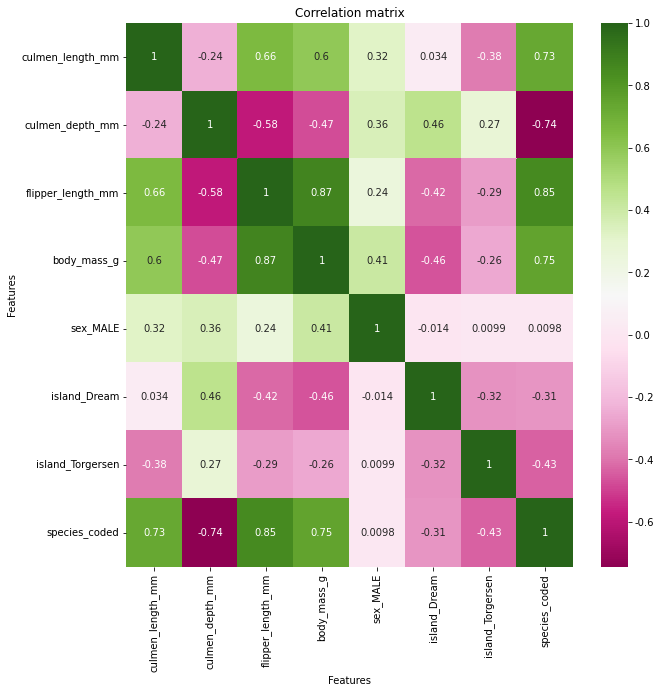

In [ ]:
hm = sns.heatmap(correlations, annot = True, cmap='PiYG')
hm.set(xlabel='Features', ylabel='Features', title = "Correlation matrix")
plt.rc('axes', unicode_minus=False)
plt.show()

I observe that the categorical variables *sex_MALE*, *island_Dream* and *island_Torgersen* are very weakly correlated with the numerical attributes.

I expected sex and body mass to be more strongly correlated, however that is not the case, as we can see there is only a 0.41 correlation.

The variables that are more strongly positively correlated with the species are **culmen length** (CC=0.73), **flipper length** (CC=0.85) and **body mass** (CC=0.75).

# Data preparation

A classic data preparation pipeline can include 4 steps:
1. Rescaling - to get the all the features in the same range of values
2. Standardization - to transform the features into a Gaussian distribution (mean=0 and SD=1)
3. Normalization - process of scaling individual samples to have unit norm
4. Binarization - turn non-binary data into binary data according to a threshold

With my classification goal in mind, I am interested in trying to apply MinMaxScaler as rescaling strategy and StandardScaler as standardization strategy. I will then compare the predictions made on the original data, on the rescaled data and on the standardized data.

In [ ]:
# Just a reminder of what we are working with
dummy_df.head()

,culmen_length_mm,culmen_depth_mm,flipper_length_mm,body_mass_g,sex_MALE,island_Dream,island_Torgersen,species_coded
0,39.1,18.7,181.0,3750.0,1,0,1,0
1,39.5,17.4,186.0,3800.0,0,0,1,0
2,40.3,18.0,195.0,3250.0,0,0,1,0
4,36.7,19.3,193.0,3450.0,0,0,1,0
5,39.3,20.6,190.0,3650.0,1,0,1,0


First I will split the dataset into training (x) and testing (y) data. 

I decided to divide the numerical and categorical variables because the numerical ones will undergo some preprocessing such as normalization and scaling. Applying these transformations to categorical data does not make sense, so for now I will keep them separated and I will reunite them later.

In [ ]:
values = dummy_df.values

x = values[:,0:7]           #all the raw variables
x_num = values[:,0:4]       #numerical original variables    
x_cat = values[:,4:7]       #categorical encoded variables - will NOT undergo any transformation
y = values[:,7]             #target

In [ ]:
print('Raw numerical variables \n',x_num)
print('\n')
print('Categorical variables \n', x_cat[:10])
print('\n')
print('Target\n',y)

Raw numerical variables 
 [[  39.1   18.7  181.  3750. ]
 [  39.5   17.4  186.  3800. ]
 [  40.3   18.   195.  3250. ]
 ...
 [  50.4   15.7  222.  5750. ]
 [  45.2   14.8  212.  5200. ]
 [  49.9   16.1  213.  5400. ]]


Categorical variables 
 [[1. 0. 1.]
 [0. 0. 1.]
 [0. 0. 1.]
 [0. 0. 1.]
 [1. 0. 1.]
 [0. 0. 1.]
 [1. 0. 1.]
 [1. 0. 1.]
 [1. 0. 1.]
 [1. 0. 1.]]


Target
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1

I plot again the distribution of the original numerical values so that we can make comparisons with the transformed (scaled and standardized) data.

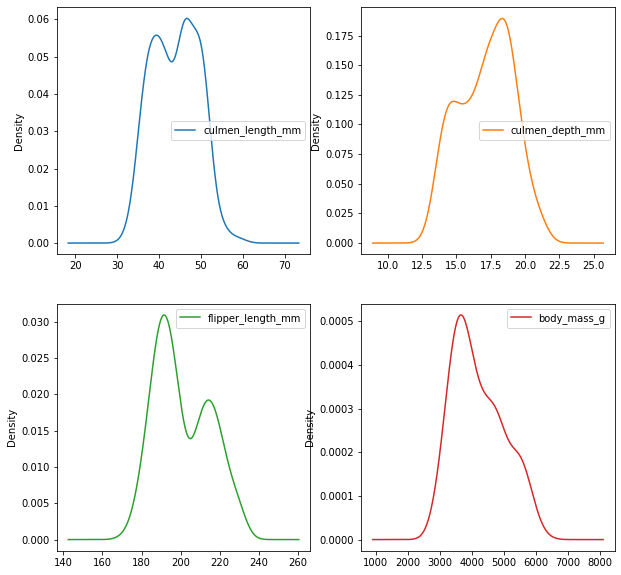

In [ ]:
original = pd.DataFrame(x_num, columns=['culmen_length_mm','culmen_depth_mm','flipper_length_mm','body_mass_g'])
original.plot(kind='density', subplots=True, layout=(2,2), sharex=False)
plt.rcParams["figure.figsize"] = [11,11]
plt.show()

## Rescaling 

I will use MinMaxScaler, which will put all the variables within the [0,1] range and preserve the shape of the original distribution.

In [ ]:
scaler = MinMaxScaler(feature_range=(0, 1))
scaled = scaler.fit_transform(x_num)

In [ ]:
print('Rescaled data \n', scaled)

Rescaled data 
 [[0.25454545 0.66666667 0.15254237 0.29166667]
 [0.26909091 0.51190476 0.23728814 0.30555556]
 [0.29818182 0.58333333 0.38983051 0.15277778]
 ...
 [0.66545455 0.30952381 0.84745763 0.84722222]
 [0.47636364 0.20238095 0.6779661  0.69444444]
 [0.64727273 0.35714286 0.69491525 0.75      ]]


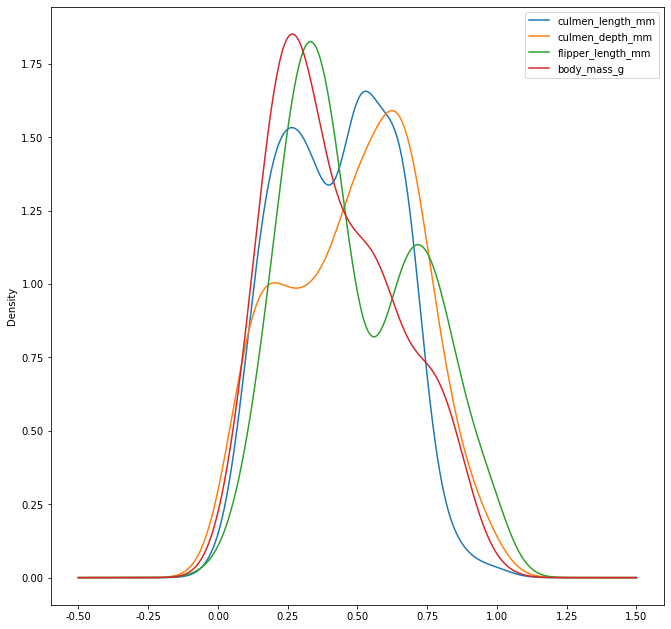

In [ ]:
#plot the rescaled data to see how the scaling affected the data
scaled_df = pd.DataFrame(scaled, columns=['culmen_length_mm','culmen_depth_mm','flipper_length_mm','body_mass_g'])
scaled_df.plot(kind='density', subplots=False, sharex=False)
plt.rcParams["figure.figsize"] = [10,10]
plt.show()

Now that I scaled the numerical values I can reunite them with the categorical columns.

In [ ]:
#vertically concatenate the scaled numerical values with the categorical values into one array
scaled_tot = np.column_stack((scaled, x_cat))
print(scaled_tot,'\n')
print('Shape: ',scaled_tot.shape)

[[0.25454545 0.66666667 0.15254237 ... 1.         0.         1.        ]
 [0.26909091 0.51190476 0.23728814 ... 0.         0.         1.        ]
 [0.29818182 0.58333333 0.38983051 ... 0.         0.         1.        ]
 ...
 [0.66545455 0.30952381 0.84745763 ... 1.         0.         0.        ]
 [0.47636364 0.20238095 0.6779661  ... 0.         0.         0.        ]
 [0.64727273 0.35714286 0.69491525 ... 1.         0.         0.        ]] 

Shape:  (342, 7)


In [ ]:
# create a dataframe to use later to extract the scaled features by column names
scaled_tot_df = pd.DataFrame(scaled_tot, columns=['culmen_length_mm','culmen_depth_mm','flipper_length_mm','body_mass_g','sex_MALE','island_Dream','island_Torgersen'])

## Standardization

As scaling startegy I will apply StandardScaler, which rescales the dataset to have a mean of 0 and a standard deviation of 1.

In [ ]:
scaler = StandardScaler()
std = scaler.fit_transform(x_num)

In [ ]:
print('Standardized data \n', std)

Standardized data 
 [[-0.88449874  0.78544923 -1.41834665 -0.56414208]
 [-0.81112573  0.1261879  -1.06225022 -0.50170305]
 [-0.66437972  0.43046236 -0.42127665 -1.18853234]
 ...
 [ 1.18828874 -0.73592307  1.50164406  1.93341896]
 [ 0.23443963 -1.19233476  0.7894512   1.24658968]
 [ 1.09657248 -0.53307343  0.86067049  1.49634578]]


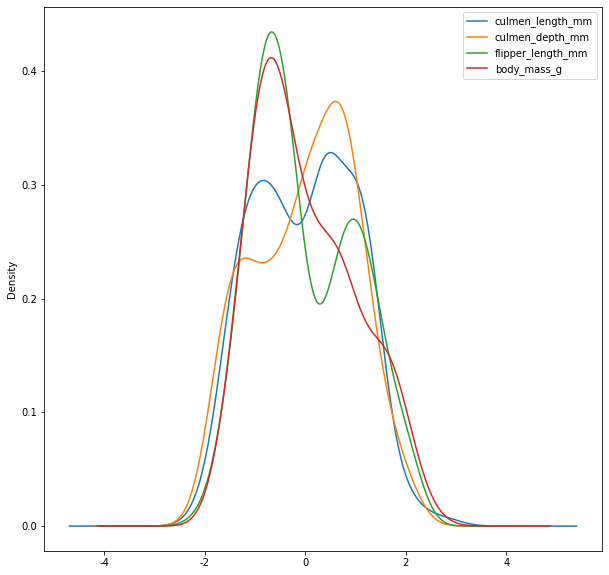

In [ ]:
#plot the standardized data to see how the standardization affected the data
std_df = pd.DataFrame(std, columns=['culmen_length_mm','culmen_depth_mm','flipper_length_mm','body_mass_g'])
std_df.plot(kind='density', subplots=False, sharex=False)
plt.rcParams["figure.figsize"] = [10,10]
plt.show()

In [ ]:
#vertically concatenate the standardized numerical values with the categorical values into one array
std_tot = np.column_stack((std, x_cat))
print(std_tot,'\n')
print('Shape: ',std_tot.shape)

[[-0.88449874  0.78544923 -1.41834665 ...  1.          0.
   1.        ]
 [-0.81112573  0.1261879  -1.06225022 ...  0.          0.
   1.        ]
 [-0.66437972  0.43046236 -0.42127665 ...  0.          0.
   1.        ]
 ...
 [ 1.18828874 -0.73592307  1.50164406 ...  1.          0.
   0.        ]
 [ 0.23443963 -1.19233476  0.7894512  ...  0.          0.
   0.        ]
 [ 1.09657248 -0.53307343  0.86067049 ...  1.          0.
   0.        ]] 

Shape:  (342, 7)


In [ ]:
# create a dataframe to use later to extract the standardized features by column names
std_tot_df = pd.DataFrame(std_tot, columns=['culmen_length_mm','culmen_depth_mm','flipper_length_mm','body_mass_g','sex_MALE','island_Dream','island_Torgersen'])

# Feature selection

The aim of feature selection is to identify the most predictive variables in the dataset in order to avoid overfitting and poor generalisation performance.
I will use Univariate Feature Selection (UFS) and I will compare the selected features based on 2 different statistical methods: chi-square test and the F-test.

In [ ]:
dummy_df.head()

,culmen_length_mm,culmen_depth_mm,flipper_length_mm,body_mass_g,sex_MALE,island_Dream,island_Torgersen,species_coded
0,39.1,18.7,181.0,3750.0,1,0,1,0
1,39.5,17.4,186.0,3800.0,0,0,1,0
2,40.3,18.0,195.0,3250.0,0,0,1,0
4,36.7,19.3,193.0,3450.0,0,0,1,0
5,39.3,20.6,190.0,3650.0,1,0,1,0


In [ ]:
#reminder of the input variables and target
print('All the raw input variables are: \n', x)
print('\n')
print('The targets are: \n', y)

All the raw input variables are: 
 [[ 39.1  18.7 181.  ...   1.    0.    1. ]
 [ 39.5  17.4 186.  ...   0.    0.    1. ]
 [ 40.3  18.  195.  ...   0.    0.    1. ]
 ...
 [ 50.4  15.7 222.  ...   1.    0.    0. ]
 [ 45.2  14.8 212.  ...   0.    0.    0. ]
 [ 49.9  16.1 213.  ...   1.    0.    0. ]]


The targets are: 
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 2. 2. 2. 2. 2

In [ ]:
# columns names in the same order as they will be given to SelectKBest
col_names = dummy_df.columns.values.tolist()
print(col_names)

['culmen_length_mm', 'culmen_depth_mm', 'flipper_length_mm', 'body_mass_g', 'sex_MALE', 'island_Dream', 'island_Torgersen', 'species_coded']


## UFS with chi-square test

In [ ]:
#chi2 as statistical test to select the best features
best_chi2 = SelectKBest(score_func=chi2, k='all')                
fit = best_chi2.fit(x, y)

np.set_printoptions(precision=3)
print(fit.scores_)
print(col_names[:7])                                             #the last column is 'species_coded', so the target 

print('\n')
for score, name in zip(fit.scores_, col_names[:7]):
  print(score.round(5),'\t',name)

[1.638e+02 5.271e+01 2.612e+02 3.495e+04 6.902e-02 1.208e+02 6.451e+01]
['culmen_length_mm', 'culmen_depth_mm', 'flipper_length_mm', 'body_mass_g', 'sex_MALE', 'island_Dream', 'island_Torgersen']


163.79784 	 culmen_length_mm
52.70586 	 culmen_depth_mm
261.17129 	 flipper_length_mm
34953.06976 	 body_mass_g
0.06902 	 sex_MALE
120.82846 	 island_Dream
64.50993 	 island_Torgersen


According to the chi-square test, the most important feature by far is ***body mass***. 
The 2nd most important feature, but much less predictive, is ***flipper length*** and then ***culmen length***. This is consistent with what we saw in the correlation matrix, where the species was strongly positively linearly correlated with exactly these 3 attributes.

Interestingly, the next most important features seem to be *island Dream* and *island Torgersen*, so categorical attributes and not a body measurement.
I want to visualize the distribution of the 3 most important attributes by species to understand how classification can rely on them.

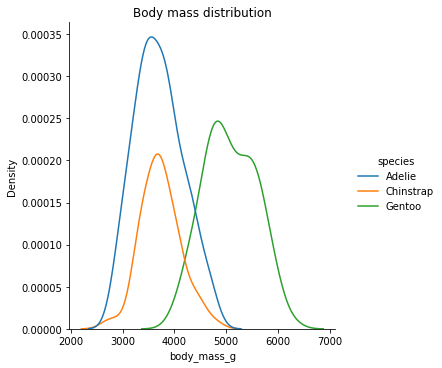

In [ ]:
fig = sns.displot(data=df, kind='kde', x='body_mass_g', hue='species').set(title='Body mass distribution')

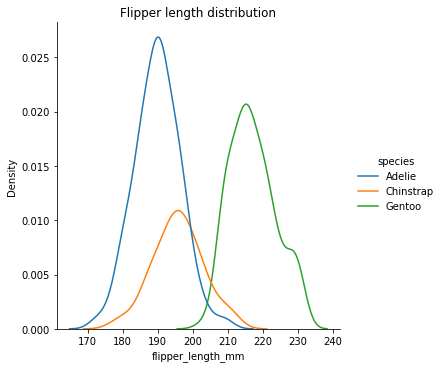

In [ ]:
fig = sns.displot(data=df, kind='kde', x='flipper_length_mm', hue='species').set(title='Flipper length distribution')

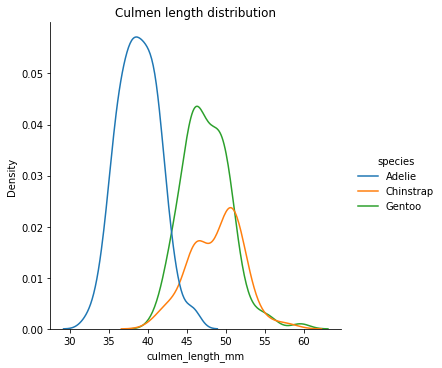

In [ ]:
fig = sns.displot(data=df, kind='kde', x='culmen_length_mm', hue='species').set(title='Culmen length distribution')

I notice that body mass and flipper length can distinguish the Gentoo species from the other two, while culmen length can discriminate the Adelie species. 

## UFS with F-test

In [ ]:
#f test as statistical test to select the best features
best_f = SelectKBest(score_func=f_classif, k='all')              
fit = best_f.fit(x, y)

np.set_printoptions(precision=3)
print(fit.scores_)
print(col_names[:7])                                        #the first column is 'species', so the target  

print('\n')
for score, name in zip(fit.scores_, col_names[:7]):
  print(score.round(5),'\t',name)

[4.106e+02 3.598e+02 5.948e+02 3.436e+02 7.093e-02 2.108e+02 4.828e+01]
['culmen_length_mm', 'culmen_depth_mm', 'flipper_length_mm', 'body_mass_g', 'sex_MALE', 'island_Dream', 'island_Torgersen']


410.60026 	 culmen_length_mm
359.78915 	 culmen_depth_mm
594.80163 	 flipper_length_mm
343.62628 	 body_mass_g
0.07093 	 sex_MALE
210.76564 	 island_Dream
48.27776 	 island_Torgersen


According to the F-test, the most important features are **flipper length**, **culmen length**, **culmen depth** and **body mass**. Differently from the chi-square test, the F-test identifies the body measurements as the most important features for the prediction of the penguin species.

We already visualized the density plots of flipper length, culmen length and body mass. By visualizing the density plot of culmen depth for the 3 species I see that this feature can distinguish the Gentoo species from the other ones.

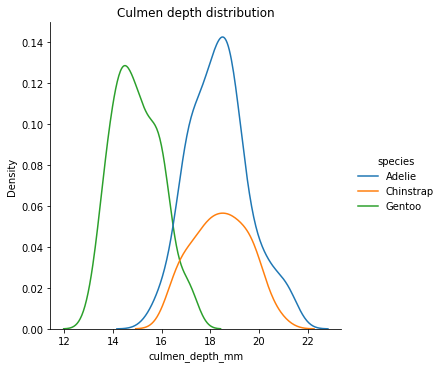

In [ ]:
fig = sns.displot(data=df, kind='kde', x='culmen_depth_mm', hue='species').set(title='Culmen depth distribution')

Both the chi-square test and the F-test identified **flipper length**, **culmen length** and **body mass** among the most important features. 

UFS using the chi-square test placed *culmen depth* as the second to last most important feature: however, seeing the results of the F-test, I am curious in comparing a model trained using all the 7 features (4 body measurements and 3 categorical attributes) with a model trained only on body measurements. Also I will make comparisons between raw, scaled and standardized data.

# 10-fold Cross Validation

I will use 10-fold CV to evaluate the model performance in classifying the penguins into species.
I will evaluate 3 different classification algorithms, Logistic Regression, Decision Tree and Support Vector Machine, trained on different input variables:
- **raw** values of **all** the 7 features 
- **raw** values of the **4** body measurement features 

- **scaled** values of **all** the 7 features 
- **scaled** values of the **4** body measurement features

- **standardized** values of **all** the 7 features 
- **standardized** values of the **4** body measurement features


In [ ]:
kfold = KFold(n_splits=10, random_state=8, shuffle=True)

# classification algorithms that I will test
models = []
models.append(('LR', LogisticRegression(solver='lbfgs', max_iter=5000)))
models.append(('CART', DecisionTreeClassifier()))
models.append(('SVM', SVC()))                                                

I will now put together a list of the input variables for the different models: all raw features, all scaled features, all standardized features, body measurement raw features, body measurement scaled features, body measurement standardized features.

In [ ]:
dataX = [('raw_all',x),('scaled_all',scaled_tot), ('std_all',std_tot)]        

#extract the 3 best features
raw_body = dummy_df[['culmen_length_mm','culmen_depth_mm','flipper_length_mm','body_mass_g']].values           # raw body measurements 
scaled_body = scaled_tot_df[['culmen_length_mm','culmen_depth_mm','flipper_length_mm','body_mass_g']].values   # scaled body measurements 
std_body = std_tot_df[['culmen_length_mm','culmen_depth_mm','flipper_length_mm','body_mass_g']].values         # standardized body measurements 

dataX.append(('raw_body',raw_body))
dataX.append(('scaled_body',scaled_body))
dataX.append(('std_body',std_body))


In [ ]:
for el in dataX:
  print(el[0])      
  print(el[1])
  print('\n')

raw_all
[[ 39.1  18.7 181.  ...   1.    0.    1. ]
 [ 39.5  17.4 186.  ...   0.    0.    1. ]
 [ 40.3  18.  195.  ...   0.    0.    1. ]
 ...
 [ 50.4  15.7 222.  ...   1.    0.    0. ]
 [ 45.2  14.8 212.  ...   0.    0.    0. ]
 [ 49.9  16.1 213.  ...   1.    0.    0. ]]


scaled_all
[[0.255 0.667 0.153 ... 1.    0.    1.   ]
 [0.269 0.512 0.237 ... 0.    0.    1.   ]
 [0.298 0.583 0.39  ... 0.    0.    1.   ]
 ...
 [0.665 0.31  0.847 ... 1.    0.    0.   ]
 [0.476 0.202 0.678 ... 0.    0.    0.   ]
 [0.647 0.357 0.695 ... 1.    0.    0.   ]]


std_all
[[-0.884  0.785 -1.418 ...  1.     0.     1.   ]
 [-0.811  0.126 -1.062 ...  0.     0.     1.   ]
 [-0.664  0.43  -0.421 ...  0.     0.     1.   ]
 ...
 [ 1.188 -0.736  1.502 ...  1.     0.     0.   ]
 [ 0.234 -1.192  0.789 ...  0.     0.     0.   ]
 [ 1.097 -0.533  0.861 ...  1.     0.     0.   ]]


raw_body
[[  39.1   18.7  181.  3750. ]
 [  39.5   17.4  186.  3800. ]
 [  40.3   18.   195.  3250. ]
 ...
 [  50.4   15.7  222.  5750. ]
 

In [ ]:
#remainder of our target y
print(y)

[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2.
 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2.
 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2.
 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2.
 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2.

Then I will run the 10-fold CV for each combination of classification algorithm and training data.

In [ ]:
# 10-fold CV run

for name,x in dataX:
  print('Training data: ',name)
  for algo,mod in models:
     res = cross_val_score(mod, x, y, scoring='accuracy', cv=kfold)
     print('Model:',algo)
     print("Accuracy: %f%% (%f%%)" % (res.mean()*100, res.std()*100))
     print('\n')
  print('---------------------------------------------------------')

Training data:  raw_all
Model: LR
Accuracy: 98.252101% (2.323890%)


Model: CART
Accuracy: 97.663866% (2.174442%)


Model: SVM
Accuracy: 73.109244% (7.204382%)


---------------------------------------------------------
Training data:  scaled_all
Model: LR
Accuracy: 99.428571% (1.714286%)


Model: CART
Accuracy: 97.672269% (2.825592%)


Model: SVM
Accuracy: 99.420168% (1.159816%)


---------------------------------------------------------
Training data:  std_all
Model: LR
Accuracy: 99.428571% (1.714286%)


Model: CART
Accuracy: 97.075630% (2.924756%)


Model: SVM
Accuracy: 99.428571% (1.714286%)


---------------------------------------------------------
Training data:  raw_body
Model: LR
Accuracy: 98.831933% (1.430769%)


Model: CART
Accuracy: 97.084034% (2.213468%)


Model: SVM
Accuracy: 72.815126% (7.241167%)


---------------------------------------------------------
Training data:  scaled_body
Model: LR
Accuracy: 97.378151% (2.719056%)


Model: CART
Accuracy: 96.798319% (3.510846%

The best performig models according to the 10-fold CV seem to be Logistic Regression and SVM trained on all scaled data and on all standardized data.
Indeed these 4 models all scored over 99% in accuracy so I will train each of them on a set of training data and then use it to predict the penguins species of a hold-out set. Finally I will compare the performance of these 4 models.

Models trained using only body measurements as features do not score as well as those trained using all the available features.

# Evaluate models performance

From the CV procedure I picked the 4 best models: LR and SVM, trained on all scaled and on all standardized data.
Now I will split the data into a training set, that will be used to train the models, and a test set that will be used to evaluate the models performance. As performance metrics I will adopt a confusion matrix and precision, recall, F1 score and support from the classification_report() function.



In [ ]:
print(models[0:4:2])        # algorithms that I want to compare

[('LR', LogisticRegression(max_iter=5000)), ('SVM', SVC())]


In [ ]:
for el in dataX[1:3]:     # training data that I want to compare
  print(el[0])
  print(el[1])
  print('\n')

scaled_all
[[0.255 0.667 0.153 ... 1.    0.    1.   ]
 [0.269 0.512 0.237 ... 0.    0.    1.   ]
 [0.298 0.583 0.39  ... 0.    0.    1.   ]
 ...
 [0.665 0.31  0.847 ... 1.    0.    0.   ]
 [0.476 0.202 0.678 ... 0.    0.    0.   ]
 [0.647 0.357 0.695 ... 1.    0.    0.   ]]


std_all
[[-0.884  0.785 -1.418 ...  1.     0.     1.   ]
 [-0.811  0.126 -1.062 ...  0.     0.     1.   ]
 [-0.664  0.43  -0.421 ...  0.     0.     1.   ]
 ...
 [ 1.188 -0.736  1.502 ...  1.     0.     0.   ]
 [ 0.234 -1.192  0.789 ...  0.     0.     0.   ]
 [ 1.097 -0.533  0.861 ...  1.     0.     0.   ]]




## Confusion matrix (CM) and classification report

In [ ]:
# combine each algorithm (LR, SVM) with each training data (scaled_all, std_all) to make the models
# for each model I split the train and test set, train the model and the make the model predict the test set

target_names = ['class 0 (Adelie)', 'class 1 (Chinstrap)', 'class 2 (Gentoo)']
all_CM = []

for mod in models[0:4:2]:
  for X in dataX[1:3]:
    X_train, X_test, Y_train, Y_test = train_test_split(X[1], y, test_size=0.33, random_state=8)   
    mod[1].fit(X_train, Y_train)                                                                   
    predicted = mod[1].predict(X_test)

    matrix = confusion_matrix(Y_test, predicted)
    report = classification_report(Y_test, predicted, target_names=target_names)  

    all_CM.append(matrix)
    
    print(mod[0],'trained on', X[0])
    print(matrix)
    print(report)
    print('-------------------------------------------------------------------')
    print('\n')

LR trained on scaled_all
[[49  0  0]
 [ 2 19  0]
 [ 0  0 43]]
                     precision    recall  f1-score   support

   class 0 (Adelie)       0.96      1.00      0.98        49
class 1 (Chinstrap)       1.00      0.90      0.95        21
   class 2 (Gentoo)       1.00      1.00      1.00        43

           accuracy                           0.98       113
          macro avg       0.99      0.97      0.98       113
       weighted avg       0.98      0.98      0.98       113

-------------------------------------------------------------------


LR trained on std_all
[[49  0  0]
 [ 2 19  0]
 [ 0  0 43]]
                     precision    recall  f1-score   support

   class 0 (Adelie)       0.96      1.00      0.98        49
class 1 (Chinstrap)       1.00      0.90      0.95        21
   class 2 (Gentoo)       1.00      1.00      1.00        43

           accuracy                           0.98       113
          macro avg       0.99      0.97      0.98       113
       weig

As we can see from the confusion matrices all these models perform very well, as there are barely any numbers outside of the diagonal, and also perform very similarly to one another. However the best performing model is SVM trained on all the scaled features: indeed this model only makes one wrong prediction. 

The SVM model trained on all the scaled features has the perfect score for precision and recall for the Gentoo species (class 2). 
Regarding the Chinstrap species (class 1), precision is 1 while recall is 0.95: meaning that all the penguins that were classified as Chinstrap indeed belong to that species, but some Chinstrap penguins were not identified. Conversely, recall for the Adelie species (class 0) is 1 but precision is 0.98.

Let's visualize its confusion matrix more in depth.

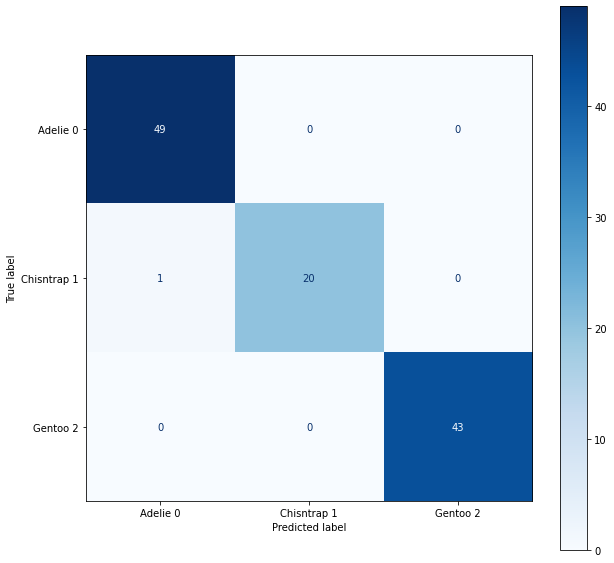

In [ ]:
SVM_all_scaled_CM = all_CM[2]
disp = ConfusionMatrixDisplay(confusion_matrix=SVM_all_scaled_CM, display_labels=['Adelie 0','Chisntrap 1','Gentoo 2'])
disp.plot(cmap=plt.cm.Blues)
plt.show()

From the confusion matrix I understand that one Chinstrap penguin was misclassified as an Adelie penguin, thus decreasing the recall score for Chinstrap and decreasing the precision score for Adelie.

From the initial exploration of the categorical variables we observed that the Chinstrap species is the least represented one in the dataset (Adelie: 152 -
Chinstrap: 68 - Gentoo: 124). This may be the reason why the model made a classification error on the Chinstrap species: I suspect that the model could take advantage from enriching the dataset of Chinstrap penguins.

# Final thoughts on this ML approach

In conclusion, I build a ML classification model that is able to classify the penguins from the Palmer Penguin dataset into 3 species with an average F1-score of 0.977 (standard deviation = 0.025). 

To do so, I firstly removed from the dataset the penguins that were lacking all body measurements information and then I imputed the missing sex data using the *most frequent* strategy.

Then I preprocessed the data: the numerical attributes were rescaled and standardized, while the categorical attributes were one-hot encoded.

Then I used 10-fold cross validation to compare different models: some trained on all the features, others trained only on body measurement features, which were either raw, rescaled or standardized. Doing so allowed me to select the best performing models, which resulted to be Logistic Regression and Support Vector Machine, trained on all scaled and on all standardized features.
I empirically observed that reducing the number of features to only the body measurements did not improve the classification performance. The reason may be that the Palmer Penguin dataset does not contain such a high number of attributes to make feature selection necessary.


Then I split the dataset into training (2/3) and testing (1/3) set and evaluated the prediction performance of the models on the test set. The best model turned out to be SVM trained on all the scaled features (average F1-score = 0.97, std = 0.025). 

The SVM model correctly predicted all penguins expect for one belonging to the Chinstrap species. In the Palmer Penguin dataset there are only half as many Chinstrap penguins as there are Adelie and Gentoo, so the under-representation of this species may be the reason for the misclassification.